In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import os

di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/ice_to_rock'

NHALO = 4
IC_FILE = 'MOM_IC.nc' # MOM6 output, coordinated with MOM_input & MOM_override
SHELF_IC_FILE = 'MOM_Shelf_IC.nc' # MOM6 output, coordinated with MOM_input & MOM_override
PROG_FILE = 'prog.nc' # MOM6 output, coordinated with diag_table
ICE_SHELF_FILE = '/INPUT/shelfX.nc'
TOPO_FILE = '/INPUT/topogX.nc'
THICKNESS_FILE = '/INPUT/thickness.nc'

In [2]:
### New shelf
def make_shelf(filename):
    
    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:,:120] = 4000000 # ice
    #new_shelf["area"][:,60:120] = 4000000 # rock
    #new_shelf["area"][:,:60] = 0 # rock
    new_shelf["area"][:,120:] = 0
 
    bb4 = 333.2*np.ones(240)
    iip = 5
    for j in range(iip):
        bb4[120-j] = bb4[120-iip]*j/iip
    bb4[120:] = 0
    #bb4[:60] = 0 # rock
    new_shelf["thick"][:,:] = bb4

    new_shelf.close()    

In [7]:
### Make symmetric version of '/INPUT/Ocean1_3D.nc'
### symmetrized version to be stored in 'filename'
def symmetrize_ocean1(filename):
    
    isf = xr.open_dataset(di + "/INPUT/Ocean1_3D.nc")
    l_thick = isf.thick[:20,:]
    r_thick = np.flip(l_thick, axis=0)
    l_area = isf.area[:20,:]
    r_area = np.flip(l_area, axis=0)

    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:20,:] = l_area.data
    new_shelf["thick"][:20,:] = l_thick.data
    new_shelf["area"][20:,:] = r_area.data
    new_shelf["thick"][20:,:] = r_thick.data

    new_shelf.close()    

In [3]:
### New topography
def make_topography(filename):
    
    new_topog = nc.Dataset(filename, "w", format="NETCDF4")
    new_topog.createDimension("ny", 40)
    new_topog.createDimension("nx", 240)
    new_topog.createVariable("depth","f8",("ny","nx"))

    new_topog["depth"][:,:60] =  290  #(rock=0/ice=290)
    new_topog["depth"][:,60:] =  720

    new_topog.close()

In [4]:
### Turn an ice column into rock whenever the ice part and the rock part meets 
### Depends on MOM6 output in IC_FILE and SHELF_IC_FILE
def rockify(shelf_filename, topo_filename):
    
    ice_shelf = xr.open_dataset(di + '/' + SHELF_IC_FILE)
    ic = xr.open_dataset(di + '/' + IC_FILE)
    eta = ic.eta[0].data[0]
    bathyT = eta - np.sum(ic.h[0].data, axis=0)

    print(np.nanmin(eta-bathyT))

    new_shelf = nc.Dataset(shelf_filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))
    new_shelf["thick"][:,:] = np.where(eta-bathyT<1e-3,[0],ice_shelf.h_shelf)
    new_shelf.close()

    new_topog = nc.Dataset(topo_filename, "w", format="NETCDF4")
    new_topog.createDimension("ny", 40)
    new_topog.createDimension("nx", 240)
    new_topog.createVariable("depth","f8",("ny","nx"))
    new_topog["depth"][:,:] = np.where(eta-bathyT<1e-3,[0],-bathyT)
    new_topog.close()

    ice_shelf.close()
    ic.close()

In [5]:
### new thickness file for THICKNESS_CONFIG="thickness_file"
### depends on MOM6 output in IC_FILE
def make_thickness_file(filename):
    
    ic = xr.open_dataset(di + '/' + IC_FILE)
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()

In [6]:
### 3D depiction of topography and ice shelf
### depends on MOM6 output in IC_FILE and SHELF_IC_FILE
def display_config():
    
    ic = xr.open_dataset(di + "/"+ IC_FILE)
    ms = xr.open_dataset(di + "/" + SHELF_IC_FILE)
    #ms = xr.open_dataset(di + "/" + ICE_SHELF_FILE)
    #tp = xr.open_dataset(di + "/" + TOPO_FILE)

    LY, LX = ic.h.data[0].shape[1], ic.h.data[0].shape[2]
    YY= np.arange(0, LY, 1)
    XX = np.arange(0, LX, 1)
    XX, YY = np.meshgrid(XX, YY)

    fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (10,4), subplot_kw={"projection": "3d"})

    surf = axes[0].plot_surface(XX, YY, ms.h_shelf.data[0])
    #surf = axes[0].plot_surface(XX, YY, ms.thick.data)
    axes[0].set_title("Input ICE SHELF h")

    eta = ic.eta[0].data[0]
    bathyT = eta - np.sum(ic.h[0].data, axis=0)
    #eta = np.where(eta-bathyT<1, [np.nan], eta)

    axes[1].plot_surface(XX, YY, bathyT, color='C1')
    axes[1].plot_surface(XX, YY, eta, color='C0')
    #topo2 = axes[1].plot_surface(XX, YY, -tp.depth.data)

    axes[1].set_title("Initial TOPOGRAPHY and ICE SHELF")

    ms.close()
    ic.close()

In [ ]:
ice_shelf = xr.open_dataset(di + '/' + SHELF_IC_FILE)
ic = xr.open_dataset(di + '/' + IC_FILE)
eta = ic.eta[0].data[0]
bathyT = eta - np.sum(ic.h[0].data, axis=0)
plt.imshow(np.where(eta-bathyT<1e-3,[0],[1])[:,:70])
plt.colorbar(shrink=0.5)

In [ ]:
!cat input.nml | tail

In [ ]:
!cat diag_table | head

In [ ]:
! cat MOM_override | tail 

In [17]:
#make_shelf(di + ICE_SHELF_FILE)
#make_topography(di + TOPO_FILE)
#rockify(di + ICE_SHELF_FILE, di + TOPO_FILE)
make_thickness_file(di + THICKNESS_FILE)
#symmetrize_ocean1(di + ICE_SHELF_FILE)

In [ ]:
tp=xr.open_dataset(di + '/' + "/INPUT/topogX.nc")
plt.imshow(tp.depth.data[:,:70])
plt.colorbar(shrink=0.5)

In [ ]:
ic=xr.open_dataset(di + '/' + IC_FILE)
plt.imshow(ic.eta[0].data[0,:,:])
plt.colorbar(shrink=0.5)

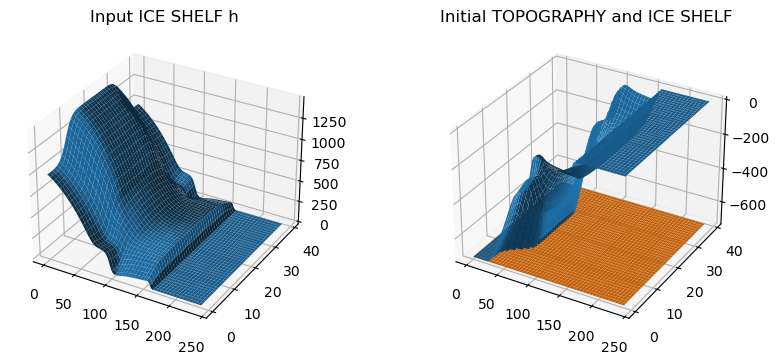

In [9]:
display_config()

### Plot output h,e,salt etc at chosen time

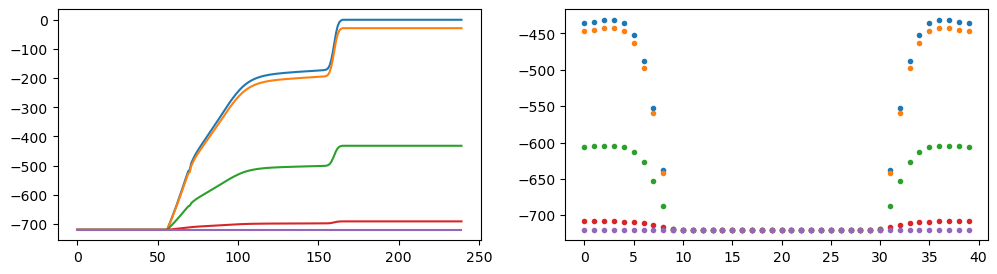

In [81]:
prog = xr.open_dataset(di + '/'+PROG_FILE)
     
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,3))
tt=0; zz= 15; yy=9; xx=56; ll = [0,1,zz,-2,-1] # ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(prog.e[tt][zzz].data[yy,:])
    axes[1].plot(prog.e[tt][zzz].data[:,xx],'.')

In [74]:
np.nanmin(prog.h[0].data)

1e-10

ttt = 0; zzz = 0
plt.plot(prog.salt.data[ttt][zzz][yy,:])

In [75]:
tt = -1
print(np.nanmax(prog.u.data[tt]), np.nanmin(prog.u.data[tt]))  # 1 day: 0.0022847548540978224 -0.005162106675472433

0.00032451863257108095 -0.0027231623132772482


In [76]:
print(np.nanmax(prog.v.data[tt]), np.nanmin(prog.v.data[tt])) #  1 day: 0.0143201571685 (7,32,53)-0.005102401052907

0.0024648172992872406 -0.0024648172992872406


In [77]:
arr = prog.v.data[tt]
ind = np.unravel_index(np.nanargmin(arr),arr.shape)
print(arr[ind])
ind

-0.0024648172992872406


(15, 9, 56)

In [78]:
np.nanmin(prog.e.data[0])

-720.0

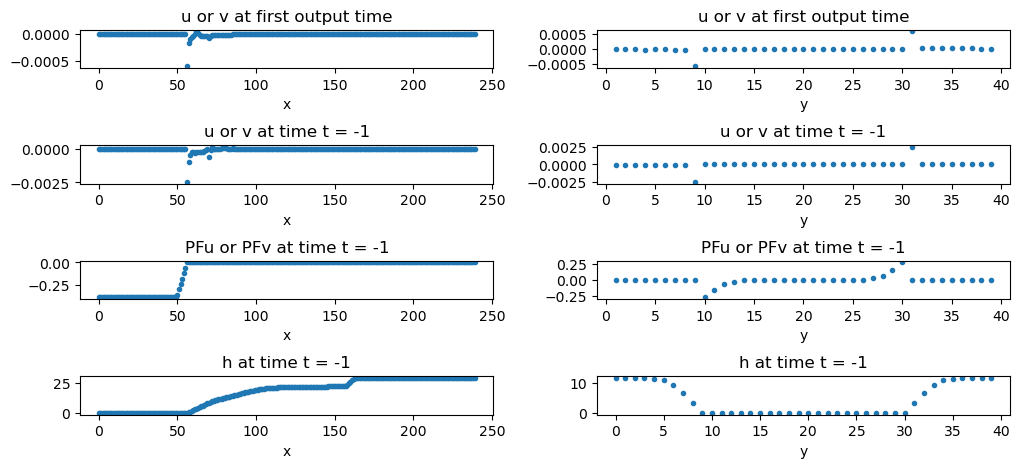

In [79]:
#aft = xr.open_dataset(di + '/after_ts_2_u.nc') # works only for 1 core, shows u after 1 time step
mo = xr.open_dataset(di + '/mom.nc')

fig,axes = plt.subplots(nrows = 4, ncols = 2, figsize = (12,5))

tt=-1; zz=15; yy=9; xx=56
prog_field = prog.v
mo_field = mo.PFv

#axes[0,0].plot(aft.u.data[zzz,yy+NHALO,NHALO:-NHALO])
axes[0,0].plot(prog_field[0][zz].data[yy,:],'.')
axes[0,0].set_xlabel("x")
axes[0,0].set_title("u or v at first output time") # depends on diag_table setting
#axes[0,1].plot(aft.u.data[zzz,NHALO:-NHALO,xx+NHALO],'o')
axes[0,1].plot(prog_field[0][zz].data[:,xx],'.')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("u or v at first output time") # depends on diag_table setting
axes[1,0].plot(prog_field[tt][zz].data[yy,:],'.',)
axes[1,0].set_xlabel("x")
axes[1,0].set_title("u or v at time t = {}".format(tt))
axes[1,1].plot(prog_field[tt][zz].data[:,xx],'.')
axes[1,1].set_xlabel("y")
axes[1,1].set_title("u or v at time t = {}".format(tt))
axes[2,0].plot(mo_field[tt][zz].data[yy,:],'.')
axes[2,0].set_xlabel("x")
axes[2,0].set_title("PFu or PFv at time t = {}".format(tt))
axes[2,1].plot(mo_field[tt][zz].data[:,xx],'.',)
axes[2,1].set_xlabel("y")
axes[2,1].set_title("PFu or PFv at time t = {}".format(tt))
axes[3,0].plot(prog.h[tt][zz].data[yy,:],'.')
axes[3,0].set_xlabel("x")
axes[3,0].set_title("h at time t = {}".format(tt))
axes[3,1].plot(prog.h[tt][zz].data[:,xx],'.',)
axes[3,1].set_xlabel("y")
axes[3,1].set_title("h at time t = {}".format(tt))

plt.subplots_adjust(wspace = 0.25, hspace = 2.0)

mo.close()

Text(0.5, 1.0, 'forcing at time t = -1')

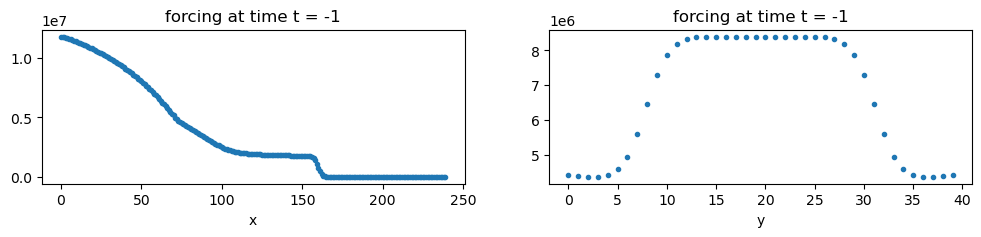

In [80]:
fc = xr.open_dataset(di + '/forcing.nc')

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,2))

tt=-1; yy=9; xx=56

#fc_field = fc.taux
#fc_field = fc.tauy
#fc_field = fc.ustar
#fc_field = fc.PRCmE
fc_field = fc.p_surf

#axes[0,0].plot(aft.u.data[zzz,yy+NHALO,NHALO:-NHALO])
axes[0].plot(fc_field[tt].data[yy,:],'.')
axes[0].set_xlabel("x")
axes[0].set_title("forcing at time t = {}".format(tt)) # depends on diag_table setting
axes[1].plot(fc_field[tt].data[:,xx],'.')
axes[1].set_xlabel("y")
axes[1].set_title("forcing at time t = {}".format(tt)) # depends on diag_table setting

ice=xr.open_dataset(di + '/' + "ice.nc")

np.unique(ice.melt_rate[-1].data)

np.unique(ice.mass_flux[-1].data)

np.unique(ice.tfreeze[-1].data)

np.unique(ice.haline_driving[-1].data)

np.unique(ice.thermal_driving[-1].data)

np.unique(ice.tflux_shelf[-1].data)

np.unique(ice.ustar_shelf[-1].data)

np.unique(ice.exch_vel_s[-1].data)

np.unique(ice.exch_vel_t[-1].data)